In [1]:
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
from time import time
import datetime
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
cd drive/MyDrive/Colab Notebooks/yapay zeka veriler

/content/drive/MyDrive/Colab Notebooks/yapay zeka veriler


In [4]:
train_path = './Dataset/train'
valid_path = './Dataset/val'
test_path = './Dataset/test'
img_size =  (224,224,3)
BATCH_SIZES = 8
EPOCHS = 30

In [5]:
datagen = ImageDataGenerator(rotation_range = 40,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             channel_shift_range = 10,
                             horizontal_flip = True,
                             fill_mode = 'nearest')

In [6]:
train_batches = datagen.flow_from_directory(directory = train_path, 
                                                  color_mode = "rgb",
                                                  target_size = (224,224),
                                                  interpolation = 'bicubic',
                                                  class_mode = "categorical", 
                                                  shuffle = True,
                                                  batch_size = BATCH_SIZES)

valid_batches = datagen.flow_from_directory(directory = valid_path,
                                            color_mode = "rgb",
                                            target_size = (224,224),
                                            interpolation = 'bicubic',
                                            class_mode = "categorical",
                                            shuffle = False,
                                            batch_size = BATCH_SIZES)

test_batches = datagen.flow_from_directory(directory = test_path,
                                           color_mode = "rgb",
                                           target_size = (224,224),
                                           interpolation = 'bicubic',
                                           class_mode = "categorical",
                                           shuffle = False,
                                           batch_size = BATCH_SIZES)

Found 306 images belonging to 2 classes.
Found 131 images belonging to 2 classes.
Found 87 images belonging to 2 classes.


In [7]:
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam 
from keras.preprocessing.image import ImageDataGenerator

In [21]:
# construct Model
res50 = ResNet50(input_shape = img_size,
                 weights = "imagenet",
                 include_top = False)
x = GlobalAveragePooling2D()(res50.output)
output = Dense(2, activation = 'softmax')(x)
model = Model(inputs = res50.input, outputs = output, name = "resnet50_transfer")

# freeze some layers
for ind,layer in enumerate(model.layers):
    if layer.name == "conv2_block3_3_conv":
        freeze_layer = ind
for layer in model.layers[:freeze_layer]:
    layer.trainable = False
for layer in model.layers[freeze_layer:]:
    layer.trainable = True
model.summary()

Model: "resnet50_transfer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                  

In [22]:
callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=6, verbose=1, min_lr = 1e-7)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_batches,
                    validation_data = valid_batches,
                    epochs= EPOCHS, 
                    shuffle = True)


Epoch 1/30
39/39 [==============================] - 37s 261ms/step - loss: 0.4906 - accuracy: 0.7647 - val_loss: 0.3731 - val_accuracy: 0.8626
Epoch 2/30
39/39 [==============================] - 8s 202ms/step - loss: 0.1871 - accuracy: 0.9150 - val_loss: 0.8364 - val_accuracy: 0.8092
Epoch 3/30
39/39 [==============================] - 8s 212ms/step - loss: 0.1726 - accuracy: 0.9412 - val_loss: 1.4375 - val_accuracy: 0.8168
Epoch 4/30
39/39 [==============================] - 9s 240ms/step - loss: 0.2381 - accuracy: 0.8922 - val_loss: 0.6141 - val_accuracy: 0.8702
Epoch 5/30
39/39 [==============================] - 11s 279ms/step - loss: 0.1356 - accuracy: 0.9346 - val_loss: 0.5243 - val_accuracy: 0.8931
Epoch 6/30
39/39 [==============================] - 8s 200ms/step - loss: 0.1331 - accuracy: 0.9510 - val_loss: 0.5417 - val_accuracy: 0.8855
Epoch 7/30
39/39 [==============================] - 9s 234ms/step - loss: 0.1982 - accuracy: 0.9314 - val_loss: 0.6186 - val_accuracy: 0.8626
Epoc

In [24]:
score = model.evaluate(test_batches)
print("Accuracy: ",score[1])

11/11 [==============================] - 2s 159ms/step - loss: 0.3619 - accuracy: 0.9425
Accuracy:  0.9425287246704102


In [25]:
from sklearn.metrics import classification_report
test_labels = test_batches.classes 
predictions = model.predict(test_batches, verbose=1)
y_pred = np.argmax(predictions, axis=-1)
print(classification_report(test_labels, y_pred, target_names = test_batches.class_indices))

11/11 [==============================] - 3s 154ms/step
              precision    recall  f1-score   support

       Curuk       0.88      0.79      0.84        29
        Taze       0.90      0.95      0.92        58

    accuracy                           0.90        87
   macro avg       0.89      0.87      0.88        87
weighted avg       0.90      0.90      0.90        87



In [26]:
model.save_weights("resnet50_final.h")

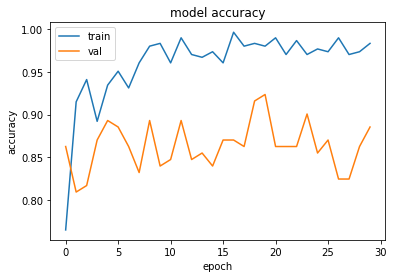

In [27]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

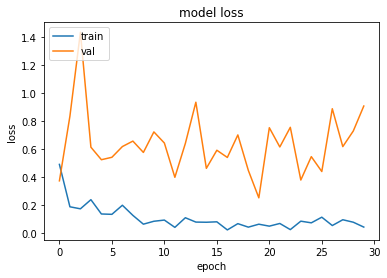

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

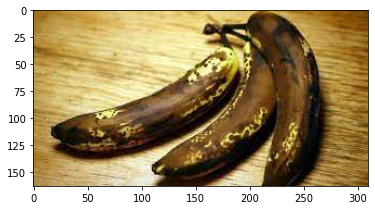

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("curuk (1).jpg")
plt.imshow(image)
plt.show()

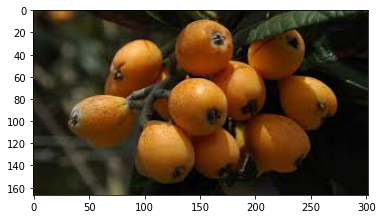

In [81]:
import os
import imageio
from matplotlib import pyplot as PLT

img_file = os.path.expanduser("malta.jpg")
M = imageio.imread(img_file)
M.shape
PLT.imshow(M)

In [82]:
img = cv2.resize(M,(224,224))
import numpy
img = img[numpy.newaxis,:,:]
prediction = model.predict(img)
prediction

1/1 [==============================] - 0s 28ms/step


array([[1.000000e+00, 9.310006e-09]], dtype=float32)

In [83]:
numpy.argmax(prediction)

0